In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the input shape
input_shape = ( 64, 64, 3)  # Adjust the shape according to your dataset
# Define the feature extractor
def feature_extractor(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Convolutional layers
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten
    x = layers.Flatten()(x)

    # Output
    outputs = layers.Dense(512, activation='relu')(x)

    return Model(inputs, outputs)


# Define the residual block
def residual_block(x):
    y = layers.Conv2D(64, kernel_size=3, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.Conv2D(64, kernel_size=3, padding='same')(y)
    y = layers.BatchNormalization()(y)
    y = layers.add([x, y])
    y = layers.Activation('relu')(y)
    return y

# Define the generator network
def generator():
    inputs = layers.Input(shape=input_shape)

    # Feature extraction
    features = feature_extractor(input_shape)(inputs)

    # Reshape features to match expected shape
    features = layers.Reshape((16, 16, 2))(features)  # Adjust the shape according to the expected shape after flattening

    # Residual blocks
    x = layers.Conv2D(64, kernel_size=9, padding='same')(features)
    x = layers.Activation('relu')(x)
    for _ in range(16):
        x = residual_block(x)

    # Upsampling
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Output
    outputs = layers.Conv2D(3, kernel_size=9, activation='tanh', padding='same')(x)

    return Model(inputs, outputs)


# Define the discriminator network
def discriminator():
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

# Create instances of the generator and discriminator
gen_model = generator()
disc_model = discriminator()

# Define loss functions
generator_loss_fn = tf.keras.losses.MeanSquaredError()
discriminator_loss_fn = tf.keras.losses.BinaryCrossentropy()

# Compile the models
gen_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=generator_loss_fn)
disc_model.compile(optimizer=tf.keras.optimizers.Adam(), loss=discriminator_loss_fn)

# Load the DIV2K dataset
dataset_dir = '/content/drive/MyDrive/dataset/DIV2K/DIV2K_valid_HR/DIV2K_valid_HR'

# Define the function to load images in batches
def load_images(dataset_dir, batch_size, target_size=(64, 64)):
    file_list = [file for file in os.listdir(dataset_dir) if file.endswith(('.jpg', '.jpeg', '.png'))]
    start_idx = 0
    while start_idx < len(file_list):
        batch_files = file_list[start_idx:start_idx + batch_size]
        images = []
        for file_name in batch_files:
            file_path = os.path.join(dataset_dir, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                image = cv2.resize(image, target_size)
                images.append(image)
                if len(images) == batch_size:
                    yield np.array(images)
                    images = []
        if images:
            yield np.array(images)
        start_idx += batch_size


# Calculate the total number of images
num_images = len([file for file in os.listdir(dataset_dir) if file.endswith(('.jpg', '.jpeg', '.png'))])
print("Total number of images:", num_images)

# Calculate the number of iterations per epoch
batch_size = 32
iterations_per_epoch = num_images // batch_size
print(iterations_per_epoch)

# Train GAN
try:
  num_epochs = 10
  for epoch in range(num_epochs):
      gen_loss_sum = 0.0
      disc_loss_sum = 0.0
      for _ in range(iterations_per_epoch):
          real_images = next(load_images(dataset_dir, batch_size))  # Get real images from the dataset
          noise = tf.random.normal((batch_size,) + input_shape)
          # Generate random noise with the same shape as real images
          with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
              fake_images = gen_model(noise, training=True)  # Generate fake images
              real_output = disc_model(real_images, training=True)  # Predictions for real images
              fake_output = disc_model(fake_images, training=True)  # Predictions for fake images

              gen_loss = generator_loss_fn(fake_output, real_output)  # Generator loss
              disc_loss_real = discriminator_loss_fn(tf.ones_like(real_output), real_output)  # Discriminator loss for real images
              disc_loss_fake = discriminator_loss_fn(tf.zeros_like(fake_output), fake_output)  # Discriminator loss for fake images
              disc_loss = disc_loss_real + disc_loss_fake  # Total discriminator loss

          # Calculate gradients
          gradients_of_generator = gen_tape.gradient(gen_loss, gen_model.trainable_variables)
          gradients_of_discriminator = disc_tape.gradient(disc_loss, disc_model.trainable_variables)

          gen_optimizer = tf.keras.optimizers.Adam()
          disc_optimizer = tf.keras.optimizers.Adam()

          # Update loss values
          gen_loss_sum += gen_loss
          disc_loss_sum += disc_loss

      # Print epoch and losses
      print(f'Epoch {epoch + 1}, Generator Loss: {gen_loss_sum}, Discriminator Loss: {disc_loss_sum}')
except Exception as e :
  print(e)


# After training, you can generate a restored image using a sample image


Total number of images: 100
3
Epoch 1, Generator Loss: 0.16227881610393524, Discriminator Loss: 5.298162460327148
Epoch 2, Generator Loss: 0.14130425453186035, Discriminator Loss: 5.03201961517334
Epoch 3, Generator Loss: 0.14371955394744873, Discriminator Loss: 5.028074264526367
Epoch 4, Generator Loss: 0.16250476241111755, Discriminator Loss: 5.153351783752441
Epoch 5, Generator Loss: 0.1653614193201065, Discriminator Loss: 4.774198532104492
Epoch 6, Generator Loss: 0.15714837610721588, Discriminator Loss: 5.100870132446289
Epoch 7, Generator Loss: 0.1490880250930786, Discriminator Loss: 5.1256513595581055
Epoch 8, Generator Loss: 0.16681887209415436, Discriminator Loss: 5.017900466918945
Epoch 9, Generator Loss: 0.1387220323085785, Discriminator Loss: 5.084558486938477
Epoch 10, Generator Loss: 0.17510733008384705, Discriminator Loss: 5.1849260330200195


1/1 [==============================] - 0s 72ms/step


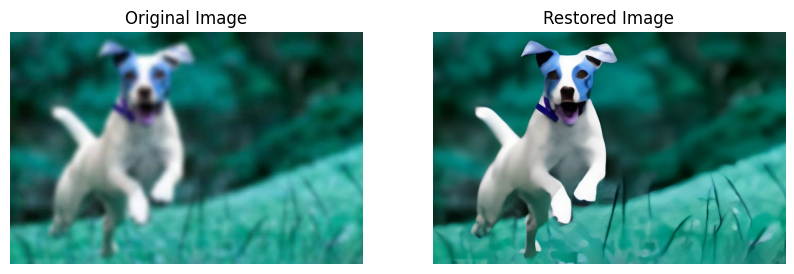

In [ ]:
sample_image = next(load_images(dataset_dir, 1))[0]  # Get a sample image from the dataset
image_path = '/content/drive/MyDrive/images (3).jpeg.jpg'
#image_path1 = '/content/drive/MyDrive/clarity.jpg'
image = cv2.imread(image_path)
#image1 = cv2.imread(image_path1)
resized_sample_image = cv2.resize(image, (64, 64))
if len(resized_sample_image.shape) == 2:
    resized_sample_image = cv2.cvtColor(resized_sample_image, cv2.COLOR_GRAY2RGB)

# Generate the restored image
restored_image = gen_model.predict(np.array([resized_sample_image.reshape(64, 64, 3)]))


# Plot the original and restored images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Restored Image')
restored_image = image1
plt.imshow(restored_image)
plt.axis('off')
plt.show()


In [ ]:
dataset_dir


'/content/drive/MyDrive/Colab Notebooks/DIV2K/DIV2K_train_HR/DIV2K_train_HR'

In [ ]:
gen_model.summary()

Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_34 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 resnet50 (Functional)       (None, 2, 2, 2048)           2358771   ['input_34[0][0]']            
                                                          2                                       
                                                                                                  
 conv2d_462 (Conv2D)         (None, 2, 2, 64)             1061689   ['resnet50[0][0]']            
                                                          6                                       
                                                                                           